# function def

In [420]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches

plt.rcParams["mathtext.fontset"] = "dejavuserif"

def get_H_pattern(L=10):
    """Generates a 2D 'H' shape pattern flattened into a vector."""
    pattern          = -np.ones((L, L))
    pattern[1:-1, 2] = 1   # Left bar
    pattern[1:-1, 7] = 1   # Right bar
    pattern[5, 2:8]  = 1    # Crossbar
    return pattern.flatten()

def get_X_pattern(L=10):
    """Generates a 2D 'X' shape pattern as a second memory example."""
    pattern = -np.ones((L, L))
    for i in range(L):
        pattern[i, i]         = 1
        pattern[i, L - 1 - i] = 1
    return pattern.flatten()

def get_plus_pattern(L=10):
    """Generates a 2D '+' shape pattern"""
    p                 = -np.ones((L,L))
    m                 = L//2
    p[:,m]            = 1
    p[m,:]            = 1
    p[:,max((m-1,0))] = 1
    p[max((m-1,0)),:] = 1
    return p.flatten()

def get_stripe_pattern(L=10):
    """Generates a 2D '+' shape pattern"""
    p      = -np.ones((L,L))
    p[:,L//3]   = 1
    p[L//3,:]   = 1
    p[:,2*L//3] = 1
    p[2*L//3,:] = 1
    return p.flatten()

def initialize_hopfield_model(patterns):
    """
    Initializes the weight matrix W using a list of patterns (Hebbian Learning).
    patterns: list of numpy arrays (flattened)
    """
    if type(patterns) is not list:
        print('initialize_hopfield_model ::: converting patterns into list of patterns')
        patterns = [patterns]
    N = len(patterns[0])
    W = np.zeros((N, N))
    for xi in patterns:
        W += np.outer(xi, xi) / N
    np.fill_diagonal(W, 0)
    return W, N, patterns

def add_noise(pattern, noise_level=0.25):
    """Randomly flips bits in a pattern."""
    s_noisy                = pattern.copy()
    N                      = len(pattern)
    flip_indices           = np.random.choice(N, size=int(noise_level * N), replace=False)
    s_noisy[flip_indices] *= -1
    return s_noisy

def iterate_hopfield_synchronous(W, s_init, max_iter=15):
    """
    Retrieves the pattern and tracks the energy at each step.
    Synchronous update retrieval: S(t+1) = sgn(W @ S(t))
    Energy E = -0.5 * S^T * W * S
    """
    s_current      = s_init.copy()
    energy_history = []
    
    # Calculate initial energy
    e_initial = -0.5 * s_current.T @ W @ s_current
    energy_history.append(e_initial)
    
    for _ in range(max_iter):
        s_next = np.sign(W @ s_current)
        s_next[s_next == 0] = 1
        
        # Calculate energy of the new state
        e_next = -0.5 * s_next.T @ W @ s_next
        energy_history.append(e_next)
        
        if np.array_equal(s_next, s_current):
            break
        s_current = s_next
        
    return s_current, np.atleast_1d(energy_history)



def iterate_hopfield_sequential(W, s_init, max_epochs=10):
    """
    Performs asynchronous (sequential) updates on the network.
    Updates neurons one by one in a random order.
    
    Returns:
        s_current: The final state of the network.
        energy_history: Energy calculated after EVERY single neuron update.
    """
    N = len(s_init)
    s_current = s_init.copy().astype(float)
    energy_history = []

    # Helper to calculate current energy: E = -0.5 * s^T * W * s
    def calculate_energy(s):
        return -0.5 * s.T @ W @ s

    # Record initial energy
    energy_history.append(calculate_energy(s_current))

    for epoch in range(max_epochs):
        # Create a random order for updating each neuron once per epoch
        indices = np.arange(N)
        np.random.shuffle(indices)
        
        changed_in_epoch = False
        
        for i in indices:
            # Calculate the local field for neuron i: h_i = sum(W_ij * s_j)
            h_i = np.dot(W[i, :], s_current)
            
            # Update rule: s_i = 1 if h_i >= 0, else -1
            new_val = 1.0 if h_i >= 0 else -1.0
            
            if new_val != s_current[i]:
                s_current[i] = new_val
                changed_in_epoch = True
            
            # Track energy after every single neuron update
            energy_history.append(calculate_energy(s_current))
            
        # If no neurons changed state during a full pass, we've hit a local minimum
        if not changed_in_epoch:
            break
            
    return s_current, np.atleast_1d(energy_history)

def plot_vector_lattice_schematic(ax,pattern,L=10,fontsize_multiplier=1,grid_multiplier=0.8):
    """
    Plots the data organized in an LxL lattice with explicit 
    vector notation (sigma_i) and index labels.
    """
    pattern = np.atleast_1d(pattern).reshape((L,L))
    # We use a slight offset to draw "boxes" rather than just an image
    ax.text(-0.5, L - 1 - 0.5, r'$\vec{\sigma}=\{$', 
            color='k', fontsize=36*fontsize_multiplier, ha='right', va='bottom', alpha=1, weight='normal')
    for y in range(L):
        for x in range(L):
            # Index formula: 1 + x + L*y (as requested)
            # Note: in plotting, y-axis usually starts from top, 
            # so we use (L - 1 - y) if you want index 1 at the top-left
            idx = 1 + x + L * y
            
            # Determine color from the pattern
            pixel_val = pattern[y, x]
            face_col = 'black' if pixel_val < 0 else 'white'
            edge_col = 'gray'
            text_col = 'white' if pixel_val < 0 else 'black'
            
            # Draw the neuron as a square box
            rect = plt.Rectangle((x - 0.5, L - 1 - y - 0.5), grid_multiplier*1, grid_multiplier*1, 
                                 facecolor=face_col, edgecolor=(0,0,0,0.8), linewidth=0.5)
            ax.add_patch(rect)
            if (x+1)*(y+1) < (L**2-1):
                ax.text(x + 0.5, L - 1 - y - 0.5, ',', 
                        color='k', fontsize=34*fontsize_multiplier, ha='right', va='bottom', alpha=1, weight='normal')
            ax.text(x-0.15, L - 1 - y-0.15, f"$\sigma_{{{idx}}}$", 
                    color=text_col, fontsize=20*fontsize_multiplier, fontweight='bold', ha='center', va='center')
            
    ax.text((L-1) + 0.8, L - 1 - (L-1) - 0.5, r'$\}$', 
                color='k', fontsize=36*fontsize_multiplier, ha='right', va='bottom', alpha=1, weight='normal')
    rect1 = plt.Rectangle((-0.5, L - 1 - (L-1) - 2.5), grid_multiplier*1, grid_multiplier*1, 
                            facecolor='w', edgecolor=(0,0,0,0.8), linewidth=0.5, clip_on=False)
    rect2 = plt.Rectangle((-0.5, L - 1 - (L-1) - 3.5), grid_multiplier*1, grid_multiplier*1, 
                            facecolor='k', edgecolor=(0,0,0,0.8), linewidth=0.5, clip_on=False)
    ax.text(2.0, L - 1 - (L-1)-0.15-2.0, "$\sigma_{i}=+1$", color='k', fontsize=28*fontsize_multiplier, fontweight='bold', ha='center', va='center')
    ax.text(2.0, L - 1 - (L-1)-0.15-3.0, "$\sigma_{i}=-1$", color='k', fontsize=28*fontsize_multiplier, fontweight='bold', ha='center', va='center')
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    # Formatting the plot
    ax.set_xlim(-1, L)
    ax.set_ylim(-1, L)
    ax.set_aspect('equal')
    ax.axis('off')

def _enlarge_axis(ax,mult,dx=0.0,dy=0.0):
    for a in np.atleast_1d(ax).flatten():
        a.set_position([box.x0 + ((1-mult)/2)*box.width+dx, box.y0 + ((1-mult)/2)*box.height+dy, box.width * mult, box.height * mult]) if (box := a.get_position()) else None
    return ax

def _unset_minor_grid(ax):
    for a in np.atleast_1d(ax).flatten():
        a.grid(False,which='minor')
    return ax

def _shift_axes_title(ax,dx=0,dy=0):
    for a in np.atleast_1d(ax).flatten():
        a.title.set_position([a.title.get_position()[0] + dx, a.title.get_position()[1] + dy])
    return ax

# running simulations

In [480]:
# --- Setup ---
np.random.seed(42)       # setting RNG seed for reproducibility
L                 = 10   # Side length
N                 = L**2 # number of neurons in the network
noise_level_input = 0.3  # for generating IC from a given pattern

# defining patterns to store
pattern_H  = get_H_pattern(L)
pattern_X  = get_X_pattern(L)
pattern_P  = get_stripe_pattern(L) #
xi_lst_all = [pattern_H, pattern_X, pattern_P] # memory list

# Initialize network with H and X memories
W_HX, _, xi_lst_HX = initialize_hopfield_model(xi_lst_all[:2])

# Iterating Hopfield model with only H and X patterns to retrieve them
s_init_HX      = [None for _ in xi_lst_HX]
s_final_HX     = [None for _ in xi_lst_HX]
E_lst_sync_HX  = [None for _ in xi_lst_HX]
E_lst_seq_HX   = [None for _ in xi_lst_HX]
for mu,xi in enumerate(xi_lst_HX):
    s_init_HX[mu]                    = add_noise(xi, noise_level=noise_level_input) # generating IC from the pattern we want to retrieve
    s_final_HX[mu],E_lst_sync_HX[mu] = iterate_hopfield_synchronous(W_HX, s_init_HX[mu])
    _             ,E_lst_seq_HX[mu]  = iterate_hopfield_sequential( W_HX, s_init_HX[mu])


# retrieving an antipattern
s_init_anti             = -s_init_HX[1] # X pattern + noise, but with sign inverted
s_final_anti,E_seq_anti = iterate_hopfield_sequential(W_HX, s_init_anti)

# retrieving hallucination (spurious pattern)
s_init_hall              = get_plus_pattern(L).reshape((L,L))
s_init_hall[3:,:]        = -1
s_init_hall              = s_init_hall.flatten()
s_final_hall,E_sync_hall = iterate_hopfield_synchronous(W_HX, s_init_hall)


# Initialize network with 'H', 'X', '#' memories
W_all, _, _     = initialize_hopfield_model(xi_lst_all)
s_init_all      = [None for _ in xi_lst_all]
s_final_all     = [None for _ in xi_lst_all]
E_lst_sync_all  = [None for _ in xi_lst_all]
E_lst_seq_all   = [None for _ in xi_lst_all]
for mu,xi in enumerate(xi_lst_all):
    s_init_all[mu]                     = add_noise(xi, noise_level=0.2)
    _              ,E_lst_sync_all[mu] = iterate_hopfield_synchronous(W_all, s_init_all[mu])
    s_final_all[mu],E_lst_seq_all[mu]  = iterate_hopfield_sequential( W_all, s_init_all[mu])

# retrieving hallucination (spurious pattern)
s0                        = xi_lst_all[1].copy().reshape((L,L))
s0[:(L//3),:]             = -1
s0[(2*L//3):,:]           = -1
s_init_hall3              = s0.flatten()
s_final_hall3,E_seq_hall3 = iterate_hopfield_sequential(W_all, s_init_hall3)



# 2 memories convergence

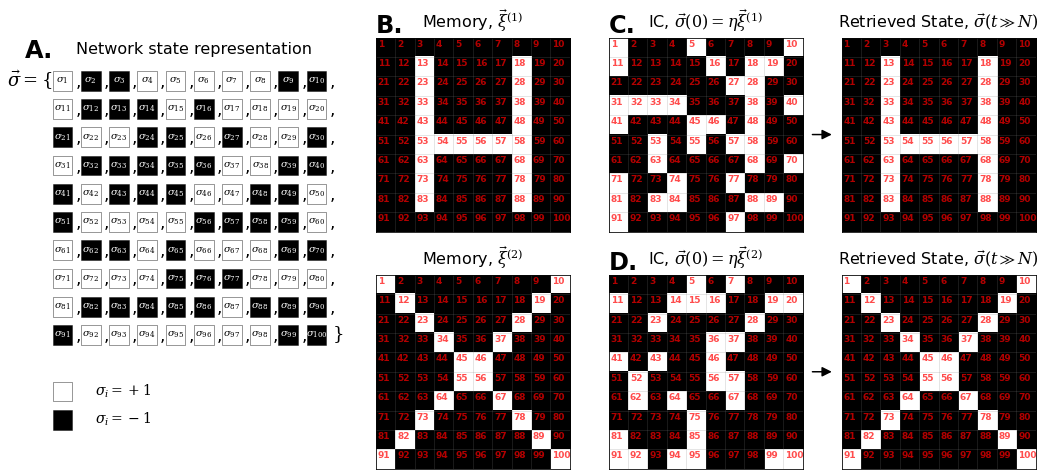

In [374]:
xi_lst  = xi_lst_HX
s_init  = s_init_HX
s_final = s_final_HX


fig, axes = plt.subplots(len(xi_lst), 4, figsize=(16, 4 * len(xi_lst)), facecolor='w')
axes[1,0].set_visible(False)


cmap = 'binary_r'

titles = [r'Memory, $\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=\eta\vec{\xi}^{(%d)}$', 
          r'Retrieved State, $\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[mu, 1:]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        # --- NEW: Add neuron indices ---
        for y in range(L):
            for x in range(L):
                n = 1 + x + L * y
                # We use a color that stands out against the binary background
                # Vertical alignment 'center' and horizontal 'center' keeps it tidy
                ax.text(x-0.4, y-0.4, str(n), color='red', fontsize=9, ha='left', va='top', alpha=0.7, weight='bold')
        # -------------------------------

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)


_enlarge_axis(axes[0,0],1.6,dx=-0.04,dy=-0.12)
plot_vector_lattice_schematic(axes[0,0],add_noise(pattern_H,0.5), L=10, fontsize_multiplier=0.5,grid_multiplier=0.7)
axes[0,0].text( 4.5, 9.7,'Network state representation',fontsize=16,ha='center',va='bottom')

axes[0,0].text(-1.5, 9.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,1].text(-0.5,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,2].text(-0.5,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,2].text(-0.5,-0.5,'D.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')


fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.05, 0.5), xyB=(-0.05, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[0,2], axesB=axes[0,3], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.05, 0.5), xyB=(-0.05, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,2], axesB=axes[1,3], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))

#plt.tight_layout()

fig.savefig('hopfield_2mem.png',dpi=300,bbox_inches='tight')

plt.show()

# hallucination and antimemory

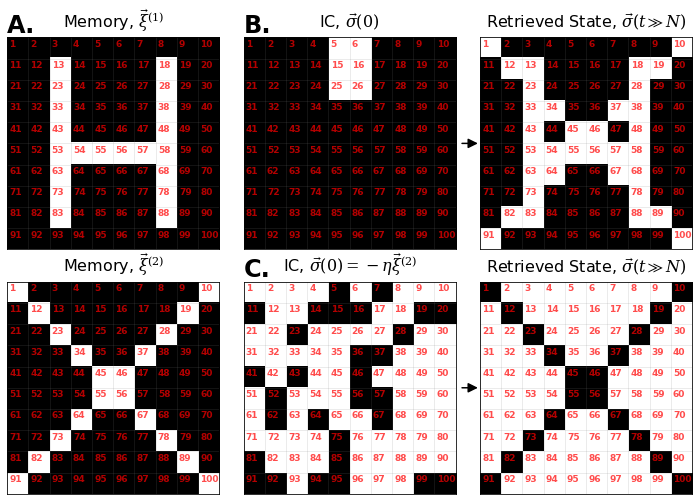

In [373]:
xi_lst  = [ xi_lst_HX[0] , xi_lst_HX[1] ]
s_init  = [ s_init_hall  , s_init_anti  ]
s_final = [ s_final_hall , s_final_anti ]

fig, axes = plt.subplots(len(xi_lst), 3, figsize=(10,1+3*len(xi_lst)), facecolor='w')


cmap = 'binary_r'

titles = [r'Memory, $\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=-\eta\vec{\xi}^{(%d)}$', 
          r'Retrieved State, $\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[mu,:]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        # --- NEW: Add neuron indices ---
        for y in range(L):
            for x in range(L):
                n = 1 + x + L * y
                # We use a color that stands out against the binary background
                # Vertical alignment 'center' and horizontal 'center' keeps it tidy
                ax.text(x-0.4, y-0.4, str(n), color='red', fontsize=9, ha='left', va='top', alpha=0.7, weight='bold')
        # -------------------------------

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-0.5,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,1].text(-0.5,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-0.5,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')

axes[0,1].set_title(r'IC, $\vec{\sigma}(0)$',fontsize=16,pad=10)

fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[0,1], axesB=axes[0,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[1,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))


fig.savefig('hopfield_2mem_hallucination_antimem_detail.png',dpi=300,bbox_inches='tight')

plt.show()

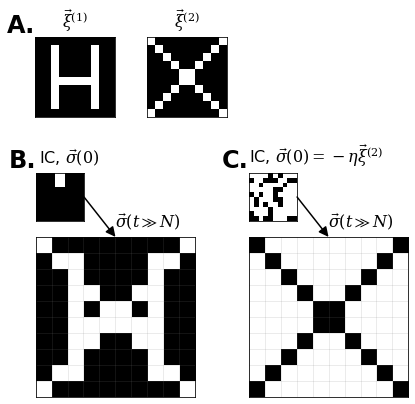

In [479]:
xi_lst  = [ xi_lst_HX[0] , xi_lst_HX[1] ]
s_init  = [ s_init_hall  , s_init_anti  ]
s_final = [ s_final_hall , s_final_anti ]

fig, axes = plt.subplots(3, len(xi_lst), figsize=(1+3*len(xi_lst),10), facecolor='w')


cmap = 'binary_r'

titles = [r'$\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=-\eta\vec{\xi}^{(%d)}$', 
          r'$\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[:,mu]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='none')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-4.0,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,0].text(-6.2,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-6.2,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')

axes[1,0].set_title(r'IC, $\vec{\sigma}(0)$',fontsize=16,pad=10)

_enlarge_axis(axes[0,0],0.5,dx= 0.0,dy=0.0)
_enlarge_axis(axes[0,1],0.5,dx=-0.2,dy=0.0)
_enlarge_axis(axes[0,:],1  ,dx=-0.08,dy=0.0)
_enlarge_axis(axes[1,:],0.3,dx=-0.11, dy=0.1)
_unset_minor_grid(axes[0:2,:])
_shift_axes_title(axes[1,0],dx=0.2,dy=-1)
_shift_axes_title(axes[1,1],dx=0.9,dy=-1)
_enlarge_axis(axes[2,:],1,dx=0, dy=0.2)
_shift_axes_title(axes[2,:],dx=0.2,dy=-1)

#fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,0], axesB=axes[2,0], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[2,1], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))


fig.savefig('hopfield_2mem_hallucination_antimem.png',dpi=300,bbox_inches='tight')

plt.show()

# 3 memories

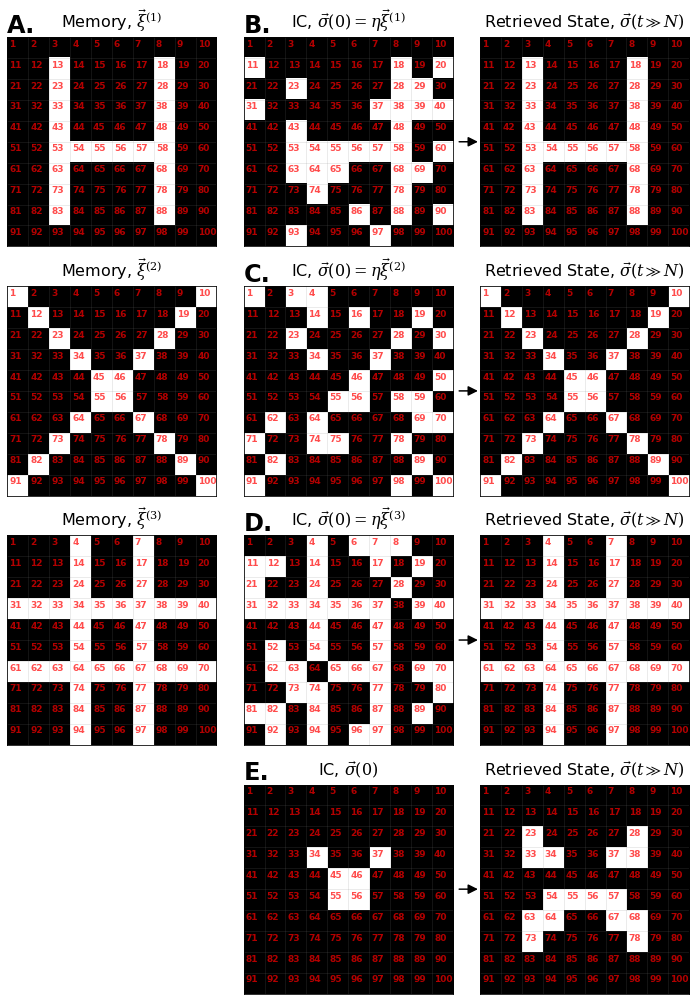

In [393]:
xi_lst  = copy.deepcopy(xi_lst_all)
s_init  = copy.deepcopy(s_init_all)
s_final = copy.deepcopy(s_final_all)

xi_lst.append( xi_lst_all[0])
s_init.append( s_init_hall3 )
s_final.append(s_final_hall3)


fig, axes = plt.subplots(len(xi_lst), 3, figsize=(10, 2+3 * len(xi_lst)), facecolor='w')
axes[3,0].set_visible(False)


cmap = 'binary_r'

titles = [r'Memory, $\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=\eta\vec{\xi}^{(%d)}$', 
          r'Retrieved State, $\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[mu,:]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        # --- NEW: Add neuron indices ---
        for y in range(L):
            for x in range(L):
                n = 1 + x + L * y
                # We use a color that stands out against the binary background
                # Vertical alignment 'center' and horizontal 'center' keeps it tidy
                ax.text(x-0.4, y-0.4, str(n), color='red', fontsize=9, ha='left', va='top', alpha=0.7, weight='bold')
        # -------------------------------

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-0.5,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[0,1].text(-0.5,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-0.5,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[2,1].text(-0.5,-0.5,'D.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[3,1].text(-0.5,-0.5,'E.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[3,1].set_title(r'IC, $\vec{\sigma}(0)$', fontsize=16, pad=10)

fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[0,1], axesB=axes[0,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[1,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[2,1], axesB=axes[2,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.03, 0.5), xyB=(-0.01, 0.5), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[3,1], axesB=axes[3,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))

fig.savefig('hopfield_3mem_detail.png',dpi=300,bbox_inches='tight')

plt.show()

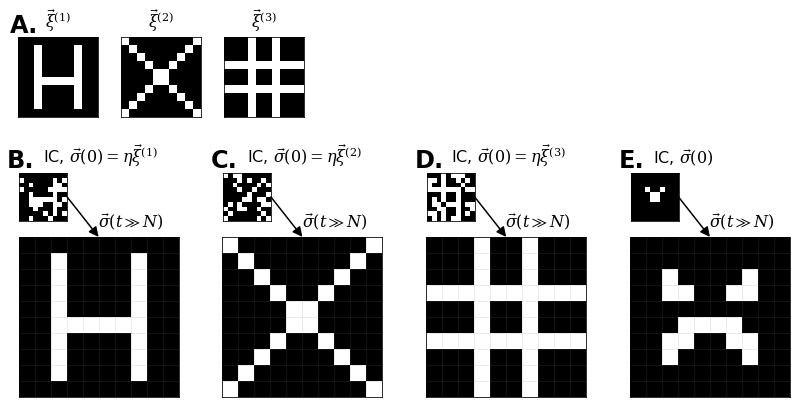

In [442]:
xi_lst  = copy.deepcopy(xi_lst_all)
s_init  = copy.deepcopy(s_init_all)
s_final = copy.deepcopy(s_final_all)

xi_lst.append( xi_lst_all[0])
s_init.append( s_init_hall3 )
s_final.append(s_final_hall3)


fig, axes = plt.subplots(3, len(xi_lst), figsize=(2+3 * len(xi_lst),10), facecolor='w')
axes[0,3].set_visible(False)


cmap = 'binary_r'

titles = [r'$\vec{\xi}^{(%d)}$', 
          r'IC, $\vec{\sigma}(0)=\eta\vec{\xi}^{(%d)}$', 
          r'$\vec{\sigma}(t\gg N)$']

# Ensure axes is 2D even if there's only one pattern
if len(xi_lst) == 1:
    axes = np.expand_dims(axes, axis=0)

for mu, (xi, s0, s1) in enumerate(zip(xi_lst, s_init, s_final)):
    data = [xi.reshape(L, L), 
            s0.reshape(L, L), 
            s1.reshape(L, L)]
    
    for i, ax in enumerate(axes[:,mu]):
        tlt = titles[i]%(mu+1) if i < 2 else titles[i]
        ax.imshow(data[i], cmap=cmap, interpolation='nearest')
        ax.set_title(tlt, fontsize=16, pad=10)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticks(np.arange(-.5, L, 1), minor=True)
        ax.set_yticks(np.arange(-.5, L, 1), minor=True)
        ax.tick_params(axis='both', which='both',bottom=False,left=False)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


axes[0,0].text(-1.5,-0.5,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,0].text(-3.0,-0.5,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,1].text(-3.0,-0.5,'C.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,2].text(-3.0,-0.5,'D.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,3].text(-3.0,-0.5,'E.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
axes[1,3].set_title(r'IC, $\vec{\sigma}(0)$', fontsize=16, pad=10)


_enlarge_axis(axes[0,0],0.5,dx=-0.04)
_enlarge_axis(axes[0,1],0.5,dx=-0.14)
_enlarge_axis(axes[0,2],0.5,dx=-0.24)
_enlarge_axis(axes[1,:],0.3,dx=-0.055, dy=0.1)
_unset_minor_grid(axes[0:2,:])
_shift_axes_title(axes[1,:3],dx=1.2,dy=-1)
_shift_axes_title(axes[1,3] ,dx=0.6,dy=-1)
_enlarge_axis(axes[2,:],1,dx=0, dy=0.2)
_shift_axes_title(axes[2,:],dx=0.2,dy=-1)

#fig.tight_layout()
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,0], axesB=axes[2,0], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,1], axesB=axes[2,1], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,2], axesB=axes[2,2], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))
fig.add_artist(mplpatches.ConnectionPatch(xyA=(1.0, 0.5), xyB=(0.5, 1.0), coordsA="axes fraction", coordsB="axes fraction", axesA=axes[1,3], axesB=axes[2,3], arrowstyle="-|>", lw=1.5, mutation_scale=20, facecolor='k'))

fig.savefig('hopfield_3mem.png',dpi=300,bbox_inches='tight')

plt.show()

# energy plot

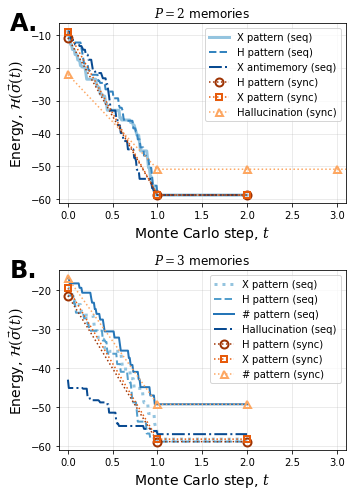

In [538]:
def _t(E,scale=1.0):
    return scale*np.arange(E.size)

# Plotting the trace
plt.rcParams["mathtext.fontset"] = "dejavuserif"
fig,ax = plt.subplots(2,1,figsize=(5,7))


colors_seq  = plt.get_cmap('Blues')(  np.linspace(0.4,0.9,10))
colors_sync = plt.get_cmap('Oranges')(np.linspace(0.4,0.9,10))


ax[0].plot(_t(E_lst_seq_HX[1] ,(1/N)),E_lst_seq_HX[1] , '-' , color=colors_seq[0] , linewidth=3  , label='X pattern (seq)'   )                                                          #'#D46600'#'#50ad9f'
ax[0].plot(_t(E_lst_seq_HX[0] ,(1/N)),E_lst_seq_HX[0] , '--', color=colors_seq[5] , linewidth=2  , label='H pattern (seq)'   )                                                          #'#1984c5'#'#0000a2'
ax[0].plot(_t(E_seq_anti      ,(1/N)),E_seq_anti      , '-.', color=colors_seq[9] , linewidth=2  , label='X antimemory (seq)')                                                          #'#D46600'#'#50ad9f'
ax[0].plot(_t(E_lst_sync_HX[0],     ),E_lst_sync_HX[0], 'o:', color=colors_sync[9], linewidth=1.5, label='H pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=8)#'#4daf4a'#'#bc272d'
ax[0].plot(_t(E_lst_sync_HX[1],     ),E_lst_sync_HX[1], 's:', color=colors_sync[5], linewidth=1.5, label='X pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=6)#'#e0169c'#'#e9c716'
ax[0].plot(_t(E_sync_hall     ,     ),E_sync_hall     , '^:', color=colors_sync[0], linewidth=1.5, label='Hallucination (sync)', markerfacecolor='none', markeredgewidth=2, markersize=7)#'#e0169c'#'#e9c716'
ax[0].set_title("$P=2$ memories")
ax[0].set_xlabel("Monte Carlo step, $t$",fontsize=14)
ax[0].set_ylabel(r"Energy, $\mathcal{H}(\vec{\sigma}(t))$",fontsize=14)
ax[0].set_xlim((-0.1,3.1))
ax[0].grid(alpha=0.3)
ax[0].legend(fontsize=10)


ax[1].plot(_t(E_lst_seq_all[1] ,(1/N)),E_lst_seq_all[1] , ':' , color=colors_seq[0], linewidth=3  , label='X pattern (seq)'    )                                                          #'#D46600'#'#50ad9f'
ax[1].plot(_t(E_lst_seq_all[0] ,(1/N)),E_lst_seq_all[0] , '--', color=colors_seq[3], linewidth=2  , label='H pattern (seq)'    )                                                          #'#1984c5'#'#0000a2'
ax[1].plot(_t(E_lst_seq_all[2] ,(1/N)),E_lst_seq_all[2] , '-' , color=colors_seq[6], linewidth=2  , label='# pattern (seq)'    )                                                          #'#1984c5'#'#0000a2'
ax[1].plot(_t(E_seq_hall3      ,(1/N)),E_seq_hall3      , '-.', color=colors_seq[9], linewidth=2  , label='Hallucination (seq)')                                                          #'#D46600'#'#50ad9f'
ax[1].plot(_t(E_lst_sync_all[0],     ),E_lst_sync_all[0], 'o:', color=colors_sync[9], linewidth=1.5, label='H pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=8)#'#4daf4a'#'#bc272d'
ax[1].plot(_t(E_lst_sync_all[1],     ),E_lst_sync_all[1], 's:', color=colors_sync[5], linewidth=1.5, label='X pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=6)#'#e0169c'#'#e9c716'
ax[1].plot(_t(E_lst_sync_all[2],     ),E_lst_sync_all[2], '^:', color=colors_sync[0], linewidth=1.5, label='# pattern (sync)'    , markerfacecolor='none', markeredgewidth=2, markersize=7)#'#e0169c'#'#e9c716'
ax[1].set_title("$P=3$ memories")
ax[1].set_xlabel("Monte Carlo step, $t$",fontsize=14)
ax[1].set_ylabel(r"Energy, $\mathcal{H}(\vec{\sigma}(t))$",fontsize=14)
ax[1].set_xlim((-0.1,3.1))
ax[1].grid(alpha=0.3)
ax[1].legend(fontsize=10)#, loc='upper right', bbox_to_anchor=(1.02,1.08))

#_shift_axes_title(ax,dx=-0.33)

ax[0].text(-0.65,-10,'A.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')
ax[1].text(-0.65,-18,'B.',color='k',fontsize=24,ha='left',va='bottom',weight='bold')

fig.tight_layout()

fig.savefig('hopfield_energy.png',dpi=300,bbox_inches='tight',facecolor='w')


plt.show()

# lattice representation of network state

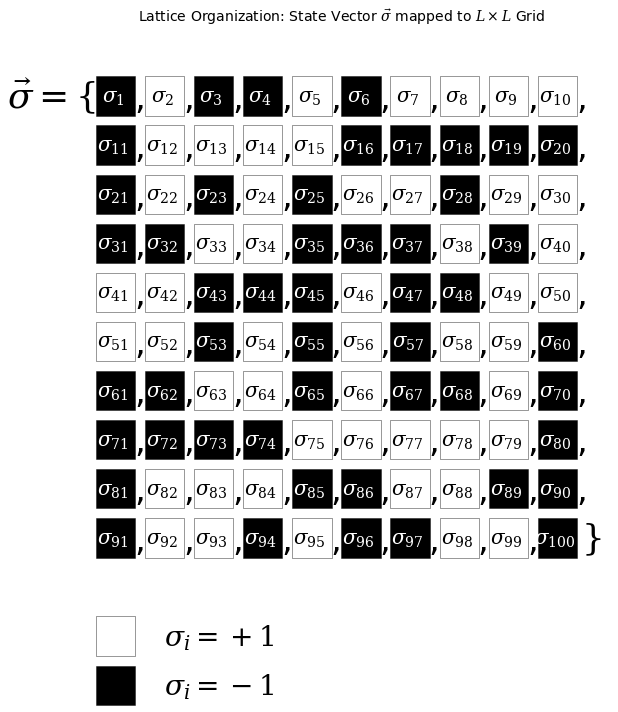

In [223]:

    
# Example usage:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='w')
plot_vector_lattice_schematic(ax,add_noise(pattern_H,0.5).reshape(10, 10), L=10)
plt.title(r"Lattice Organization: State Vector $\vec{\sigma}$ mapped to $L \times L$ Grid", 
            fontsize=14, pad=20)
    
plt.tight_layout()
plt.show()
